In [1]:
!pip install google-cloud-iot

In [2]:
!pip install google-api-python-client

In [3]:
!pip install google-cloud-storage

In [4]:
!pip install cryptography pyjwt paho-mqtt 

     |████████████████████████████████| 2.7MB 9.1MB/s 
     |████████████████████████████████| 102kB 8.7MB/s 
  Created wheel for paho-mqtt: filename=paho_mqtt-1.5.0-cp36-none-any.whl size=61416 sha256=931413b9d38a7961f4e6f64a475e82c15154d9c264d1870256c9602628543c2c
  Stored in directory: /root/.cache/pip/wheels/02/94/6c/8474137cb7a5a3e001d70a22c8ff919caee69435376bccce79
Successfully built paho-mqtt


In [0]:
import paho.mqtt.client as mqtt
import jwt
import time
import ssl
import random
import os
import logging
import datetime
import argparse

In [0]:
!wget http://blogs.sjsu.edu/newsroom/files/2020/04/sjsu-virtual-open-house-social_v2.jpg

--2020-04-26 23:34:24--  http://blogs.sjsu.edu/newsroom/files/2020/04/sjsu-virtual-open-house-social_v2.jpg
Resolving blogs.sjsu.edu (blogs.sjsu.edu)... 34.216.237.15, 34.215.37.29
Connecting to blogs.sjsu.edu (blogs.sjsu.edu)|34.216.237.15|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cpb-us-w2.wpmucdn.com/blogs.sjsu.edu/dist/f/94/files/2020/04/sjsu-virtual-open-house-social_v2.jpg [following]
--2020-04-26 23:34:24--  https://cpb-us-w2.wpmucdn.com/blogs.sjsu.edu/dist/f/94/files/2020/04/sjsu-virtual-open-house-social_v2.jpg
Resolving cpb-us-w2.wpmucdn.com (cpb-us-w2.wpmucdn.com)... 151.139.244.23
Connecting to cpb-us-w2.wpmucdn.com (cpb-us-w2.wpmucdn.com)|151.139.244.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240500 (235K) [image/jpeg]
Saving to: ‘sjsu-virtual-open-house-social_v2.jpg’

sjsu-virtual-open-h 100%[===================>] 234.86K  --.-KB/s    in 0.003s  

2020-04-26 23:34:24 (80.6 MB/s) - ‘sjsu-virtual

# Setup Google Cloud Client

In [0]:
from google.colab import auth
auth.authenticate_user()

In [8]:
!gcloud config list

[component_manager]
disable_update_check = True
[compute]
gce_metadata_read_timeout_sec = 0
[core]
account = kaikai.liu@sjsu.edu

Your active configuration is: [default]


To take a quick anonymous survey, run:
  $ gcloud survey



In [9]:
!gcloud config set compute/region us-central1

Updated property [compute/region].


In [10]:
!gcloud config set compute/zone us-central1a

Updated property [compute/zone].


In [11]:
!gcloud config list project

[core]
project (unset)

Your active configuration is: [default]


In [12]:
!gcloud config set project 'cmpelkk'

Updated property [core/project].


# Mount Google Drive

In [0]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
Trainimage_path='/content/gdrive/"My Drive"/Developer/FireProject/FireVideo/binary_dataset/train'
Validimage_path='/content/gdrive/"My Drive"/Developer/FireProject/FireVideo/binary_dataset/validation'

In [0]:
!ls {Trainimage_path}

negatives  positives


In [0]:
Trainimage_positive_path = os.path.join(Trainimage_path, 'positives')

In [0]:
!ls {Trainimage_positive_path}

00159.jpg  01165.jpg  02261.jpg  04487.jpg  05918.jpg  07160.jpg  08442.jpg
00160.jpg  01167.jpg  02304.jpg  04488.jpg  05936.jpg  07171.jpg  08449.jpg
00161.jpg  01168.jpg  02309.jpg  04495.jpg  05944.jpg  07186.jpg  08453.jpg
00162.jpg  01171.jpg  02321.jpg  04501.jpg  05958.jpg  07195.jpg  08471.jpg
00163.jpg  01172.jpg  02322.jpg  04504.jpg  05964.jpg  07213.jpg  08499.jpg
00167.jpg  01174.jpg  02323.jpg  04507.jpg  05968.jpg  07224.jpg  08513.jpg
00168.jpg  01175.jpg  02324.jpg  04508.jpg  05972.jpg  07225.jpg  08518.jpg
00175.jpg  01177.jpg  02325.jpg  04516.jpg  05976.jpg  07232.jpg  08522.jpg
00239.jpg  01185.jpg  02330.jpg  04518.jpg  05985.jpg  07236.jpg  08529.jpg
00240.jpg  01186.jpg  02337.jpg  04526.jpg  05986.jpg  07254.jpg  08536.jpg
00241.jpg  01188.jpg  02346.jpg  04528.jpg  05990.jpg  07257.jpg  08544.jpg
00242.jpg  01195.jpg  02347.jpg  04529.jpg  06002.jpg  07263.jpg  08546.jpg
00252.jpg  01196.jpg  02361.jpg  04530.jpg  06008.jpg  07273.jpg  08580.jpg
00259.jpg  0

Create a service credentials, ref: https://cloud.google.com/storage/docs/reference/libraries#client-libraries-usage-nodejs

In [0]:
myservicecredentials='/content/gdrive/"My Drive"/CurrentWork/CMPE181Sp2020/Googlecerts'

In [0]:
!ls {myservicecredentials}

cmpe181dev1  cmpelkk-134cc577da4f.json	cmpelkk-380e31c10ee7.json


In [0]:
myservicecredentials_path=os.path.join(myservicecredentials, 'cmpelkk-134cc577da4f.json')

In [0]:
!cp {myservicecredentials_path} .

In [0]:
GOOGLE_APPLICATION_CREDENTIALS='./cmpelkk-134cc577da4f.json'

In [0]:
!echo $GOOGLE_APPLICATION_CREDENTIALS

./cmpelkk-134cc577da4f.json


In [0]:
from google.cloud import storage

In [0]:
# Instantiates a client
storage_client = storage.Client.from_service_account_json('./cmpelkk-134cc577da4f.json')
#storage_client = storage.Client()

In [0]:
# The name for the new bucket
bucket_name = "cmpelkk_imageupload"
# Creates the new bucket
bucket = storage_client.create_bucket(bucket_name)
print("Bucket {} created.".format(bucket.name))

Bucket cmpelkk_imageupload created.


In [0]:
blob = bucket.blob('sjsu/img1.jpg') #(folder, filename)
blob.upload_from_filename('./sjsu-virtual-open-house-social_v2.jpg')

In [0]:
#upload image to an existing bucket
bucketexist = storage_client.bucket('cmpelkk_imagetest')
blobexist = bucketexist.blob('sjsu/img1.jpg')
blobexist.upload_from_filename('./sjsu-virtual-open-house-social_v2.jpg')

# Google Cloud Storage Gsutil

In [0]:
!gsutil ls #list google cloud storage bucket

You are attempting to perform an operation that requires a project id, with none configured. Please re-run gsutil config and make sure to follow the instructions for finding and entering your default project id.


In [0]:
filepath=os.path.join(Trainimage_positive_path, '00910.jpg')

NameError: ignored

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img 

In [0]:
import cv2 as cv


In [0]:
# reading jpg image file via opencv
img = cv.imread('./00910.jpg')

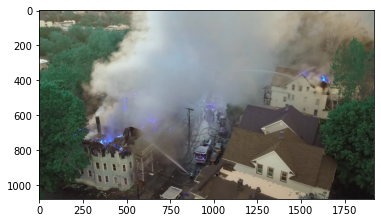

In [0]:
plt.imshow(img)
#plt.axis('off')

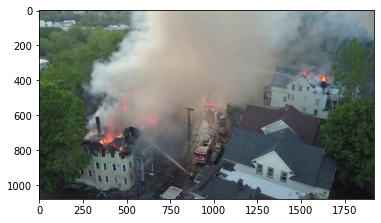

In [0]:
plt.imshow(np.real(img.imread('./00910.jpg')))#another way to read image

In [0]:
!gsutil cp filepath gs://cmpelkk_imagetest/ #copy one image to google cloud storage

In [0]:
!gsutil cp 

CommandException: Wrong number of arguments for "cp" command.


# Google IoT Defined functions

In [0]:
import paho.mqtt.client as mqtt
import jwt
import time
import ssl
import random
import os
import logging
import datetime
import argparse

from google.cloud import storage

In [0]:
# The initial backoff time after a disconnection occurs, in seconds.
minimum_backoff_time = 1

# The maximum backoff time before giving up, in seconds.
MAXIMUM_BACKOFF_TIME = 32

# Whether to wait with exponential backoff before publishing.
should_backoff = False

def create_jwt(project_id, private_key_file, algorithm):
    """Creates a JWT (https://jwt.io) to establish an MQTT connection.
        Args:
         project_id: The cloud project ID this device belongs to
         private_key_file: A path to a file containing either an RSA256 or
                 ES256 private key.
         algorithm: The encryption algorithm to use. Either 'RS256' or 'ES256'
        Returns:
            A JWT generated from the given project_id and private key, which
            expires in 20 minutes. After 20 minutes, your client will be
            disconnected, and a new JWT will have to be generated.
        Raises:
            ValueError: If the private_key_file does not contain a known key.
        """

    token = {
        # The time that the token was issued at
        'iat': datetime.datetime.utcnow(),
        # The time the token expires.
        'exp': datetime.datetime.utcnow() + datetime.timedelta(minutes=20),
        # The audience field should always be set to the GCP project id.
        'aud': project_id
    }

    # Read the private key file.
    with open(private_key_file, 'r') as f:
        private_key = f.read()

    print('Creating JWT using {} from private key file {}'.format(
        algorithm, private_key_file))

    return jwt.encode(token, private_key, algorithm=algorithm)
# [END iot_mqtt_jwt]

In [0]:
def error_str(rc):
    """Convert a Paho error to a human readable string."""
    return '{}: {}'.format(rc, mqtt.error_string(rc))


def on_connect(unused_client, unused_userdata, unused_flags, rc):
    """Callback for when a device connects."""
    print('on_connect', mqtt.connack_string(rc))

    # After a successful connect, reset backoff time and stop backing off.
    global should_backoff
    global minimum_backoff_time
    should_backoff = False
    minimum_backoff_time = 1


def on_disconnect(unused_client, unused_userdata, rc):
    """Paho callback for when a device disconnects."""
    print('on_disconnect', error_str(rc))

    # Since a disconnect occurred, the next loop iteration will wait with
    # exponential backoff.
    global should_backoff
    should_backoff = True


def on_publish(unused_client, unused_userdata, unused_mid):
    """Paho callback when a message is sent to the broker."""
    print('on_publish')


def on_message(unused_client, unused_userdata, message):
    """Callback when the device receives a message on a subscription."""
    payload = str(message.payload.decode('utf-8'))
    print('Received message \'{}\' on topic \'{}\' with Qos {}'.format(
        payload, message.topic, str(message.qos)))

In [0]:
def get_client(
        project_id, cloud_region, registry_id, device_id, private_key_file,
        algorithm, ca_certs, mqtt_bridge_hostname, mqtt_bridge_port):
    """Create our MQTT client. The client_id is a unique string that identifies
    this device. For Google Cloud IoT Core, it must be in the format below."""
    client_id = 'projects/{}/locations/{}/registries/{}/devices/{}'.format(
        project_id, cloud_region, registry_id, device_id)
    print('Device client_id is \'{}\''.format(client_id))

    client = mqtt.Client(client_id=client_id)

    # With Google Cloud IoT Core, the username field is ignored, and the
    # password field is used to transmit a JWT to authorize the device.
    client.username_pw_set(
        username='unused',
        password=create_jwt(
            project_id, private_key_file, algorithm))

    # Enable SSL/TLS support.
    client.tls_set(ca_certs=ca_certs, tls_version=ssl.PROTOCOL_TLSv1_2)

    # Register message callbacks. https://eclipse.org/paho/clients/python/docs/
    # describes additional callbacks that Paho supports. In this example, the
    # callbacks just print to standard out.
    client.on_connect = on_connect
    client.on_publish = on_publish
    client.on_disconnect = on_disconnect
    client.on_message = on_message

    # Connect to the Google MQTT bridge.
    client.connect(mqtt_bridge_hostname, mqtt_bridge_port)

    # This is the topic that the device will receive configuration updates on.
    mqtt_config_topic = '/devices/{}/config'.format(device_id)

    # Subscribe to the config topic.
    client.subscribe(mqtt_config_topic, qos=1)

    # The topic that the device will receive commands on.
    mqtt_command_topic = '/devices/{}/commands/#'.format(device_id)

    # Subscribe to the commands topic, QoS 1 enables message acknowledgement.
    print('Subscribing to {}'.format(mqtt_command_topic))
    client.subscribe(mqtt_command_topic, qos=0)

    return client
# [END iot_mqtt_config]

In [0]:
class Args:
  algorithm = 'RS256'
  ca_certs = './roots.pem' #'/content/gdrive/"My Drive"/CurrentWork/CMPE181Sp2020/Googlecerts/roots.pem'
  cloud_region = 'us-central1'
  data = 'Hello there'
  device_id = 'cmpe181dev1'
  jwt_expires_minutes = 20
  listen_dur = 60
  message_type = 'event'
  mqtt_bridge_hostname = 'mqtt.googleapis.com'
  mqtt_bridge_port = 8883
  num_messages = 20
  private_key_file = './rsa_private.pem'#/content/gdrive/"My Drive"/CurrentWork/CMPE181Sp2020/Googlecerts/cmpe181dev1/rsa_private.pem'
  project_id = 'cmpelkk'
  registry_id = 'CMPEIoT1'
  service_account_json = '/content/cmpelkk-134cc577da4f.json'#os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")
  imagefolder_path= './data'


args=Args()

In [0]:
print(args.private_key_file)

./rsa_private.pem


In [0]:
private_key_file = '/content/gdrive/"My Drive"/CurrentWork/CMPE181Sp2020/Googlecerts/cmpe181dev1/rsa_private.pem'

In [0]:
!cp {private_key_file} .

In [0]:
ca_certs = '/content/gdrive/"My Drive"/CurrentWork/CMPE181Sp2020/Googlecerts/roots.pem'
!cp {ca_certs} .

In [0]:

def parse_command_line_args():
    """Parse command line arguments."""
    parser = argparse.ArgumentParser(description=(
        'Example Google Cloud IoT Core MQTT device connection code.'))
    parser.add_argument(
        '--algorithm',
        choices=('RS256', 'ES256'),
        required=True,
        help='Which encryption algorithm to use to generate the JWT.')
    parser.add_argument(
        '--ca_certs',
        default='./roots.pem',
        help='CA root from https://pki.google.com/roots.pem')
    parser.add_argument(
        '--cloud_region', default='us-central1', help='GCP cloud region')
    parser.add_argument(
        '--data',
        default='Hello there',
        help='The telemetry data sent on behalf of a device')
    parser.add_argument(
        '--device_id', required=True, help='Cloud IoT Core device id')
    parser.add_argument(
        '--gateway_id', required=False, help='Gateway identifier.')
    parser.add_argument(
        '--jwt_expires_minutes',
        default=20,
        type=int,
        help='Expiration time, in minutes, for JWT tokens.')
    parser.add_argument(
        '--listen_dur',
        default=60,
        type=int,
        help='Duration (seconds) to listen for configuration messages')
    parser.add_argument(
        '--message_type',
        choices=('event', 'state'),
        default='event',
        help=('Indicates whether the message to be published is a '
              'telemetry event or a device state message.'))
    parser.add_argument(
        '--mqtt_bridge_hostname',
        default='mqtt.googleapis.com',
        help='MQTT bridge hostname.')
    parser.add_argument(
        '--mqtt_bridge_port',
        choices=(8883, 443),
        default=8883,
        type=int,
        help='MQTT bridge port.')
    parser.add_argument(
        '--num_messages',
        type=int,
        default=100,
        help='Number of messages to publish.')
    parser.add_argument(
        '--private_key_file',
        required=True,
        help='Path to private key file.')
    parser.add_argument(
        '--project_id',
        default=os.environ.get('GOOGLE_CLOUD_PROJECT'),
        help='GCP cloud project name')
    parser.add_argument(
        '--registry_id', required=True, help='Cloud IoT Core registry id')
    parser.add_argument(
        '--service_account_json',
        default=os.environ.get("GOOGLE_APPLICATION_CREDENTIALS"),
        help='Path to service account json file.')

    return parser.parse_args()


def mqtt_device_demo(args):
    """Connects a device, sends data, and receives data."""
    # [START iot_mqtt_run]
    global minimum_backoff_time
    global MAXIMUM_BACKOFF_TIME

    # Publish to the events or state topic based on the flag.
    sub_topic = 'events' if args.message_type == 'event' else 'state'

    mqtt_topic = '/devices/{}/{}'.format(args.device_id, sub_topic)

    jwt_iat = datetime.datetime.utcnow()
    jwt_exp_mins = args.jwt_expires_minutes
    client = get_client(
        args.project_id, args.cloud_region, args.registry_id,
        args.device_id, args.private_key_file, args.algorithm,
        args.ca_certs, args.mqtt_bridge_hostname, args.mqtt_bridge_port)

    # Publish num_messages messages to the MQTT bridge once per second.
    for i in range(1, args.num_messages + 1):
        # Process network events.
        client.loop()

        # Wait if backoff is required.
        if should_backoff:
            # If backoff time is too large, give up.
            if minimum_backoff_time > MAXIMUM_BACKOFF_TIME:
                print('Exceeded maximum backoff time. Giving up.')
                break

            # Otherwise, wait and connect again.
            delay = minimum_backoff_time + random.randint(0, 1000) / 1000.0
            print('Waiting for {} before reconnecting.'.format(delay))
            time.sleep(delay)
            minimum_backoff_time *= 2
            client.connect(args.mqtt_bridge_hostname, args.mqtt_bridge_port)

        payload = '{}/{}-payload-{}'.format(
            args.registry_id, args.device_id, i)
        print('Publishing message {}/{}: \'{}\''.format(
            i, args.num_messages, payload))
        # [START iot_mqtt_jwt_refresh]
        seconds_since_issue = (datetime.datetime.utcnow() - jwt_iat).seconds
        if seconds_since_issue > 60 * jwt_exp_mins:
            print('Refreshing token after {}s'.format(seconds_since_issue))
            jwt_iat = datetime.datetime.utcnow()
            client.loop()
            client.disconnect()
            client = get_client(
                args.project_id, args.cloud_region,
                args.registry_id, args.device_id, args.private_key_file,
                args.algorithm, args.ca_certs, args.mqtt_bridge_hostname,
                args.mqtt_bridge_port)
        # [END iot_mqtt_jwt_refresh]
        # Publish "payload" to the MQTT topic. qos=1 means at least once
        # delivery. Cloud IoT Core also supports qos=0 for at most once
        # delivery.
        client.publish(mqtt_topic, payload, qos=1)

        
        # Send events every second. State should not be updated as often
        time.sleep(1)
        # for i in range(0, 60):
        #     time.sleep(1)
        #     client.loop()
    # [END iot_mqtt_run]

In [0]:
import random
import time
import datetime
import json

def read_sensor(count):
    tempF = 20 + 0.2*count + (random.random() * 15)
    humidity = 60 + 0.3*count+ (random.random() * 20)
    temp = '{0:0.2f}'.format(tempF)
    hum = '{0:0.2f}'.format(humidity)
    sensorZipCode = 95192#"94043"
    sensorLat = 37.3382082+ (random.random() /100)#"37.421655"
    sensorLong = -121.8863286 + (random.random() /100)#"-122.085637"
    sensorLatf = '{0:0.6f}'.format(sensorLat)
    sensorLongf = '{0:0.6f}'.format(sensorLong)
    return (temp, hum, sensorZipCode, sensorLatf, sensorLongf)

def createJSON(reg_id, dev_id, timestamp, zip, lat, long, temperature, humidity, img_file):
    data = {
      'registry_id' : reg_id,
      'device_id' : dev_id,
      'timecollected' : timestamp,
      'zipcode' : zip,
      'latitude' : lat,
      'longitude' : long,
      'temperature' : temperature,
      'humidity' : humidity,
      'image_file' : img_file
    }

    json_str = json.dumps(data)
    return json_str

def storage_mqtt_device_demo(args):

    """Connects a device, sends data, and receives data."""
    # [START iot_mqtt_run]
    global minimum_backoff_time
    global MAXIMUM_BACKOFF_TIME

    # Publish to the events or state topic based on the flag.
    sub_topic = 'events' if args.message_type == 'event' else 'state'

    mqtt_topic = '/devices/{}/{}'.format(args.device_id, sub_topic)

    jwt_iat = datetime.datetime.utcnow()
    jwt_exp_mins = args.jwt_expires_minutes
    client = get_client(
        args.project_id, args.cloud_region, args.registry_id,
        args.device_id, args.private_key_file, args.algorithm,
        args.ca_certs, args.mqtt_bridge_hostname, args.mqtt_bridge_port)
    
    # Instantiates a google cloud client
    # Instantiates a client
    storage_client = storage.Client.from_service_account_json(args.service_account_json)
    #storage_client = storage.Client()
    #upload image to an existing bucket
    bucketexist = storage_client.bucket('cmpelkk_imagetest')

    i = 0
    path = args.imagefolder_path#'/Users/lkk/Documents/GoogleCloud/iotpython/data'
    for filename in os.listdir(path):
      if filename.endswith(".jpg"): 
        print(filename)#os.path.join(directory, filename))
        i+=1
        bucketfilename= "img%s.jpg" % i
        print(bucketfilename)
        blobexist = bucketexist.blob(bucketfilename)
        filepathlocal = os.path.join(path, filename)
        print(filepathlocal)
        blobexist.upload_from_filename(filepathlocal)

          # Process network events.
        client.loop()

        currentTime = datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
        (temp, hum, sensorZipCode, sensorLat, sensorLong) = read_sensor(i)
        #(id, timestamp, zip, lat, long, temperature, humidity, img_file)
        payloadJSON = createJSON(args.registry_id, args.device_id, currentTime, sensorZipCode, sensorLat, sensorLong, temp, hum, bucketfilename)

        #payload = '{}/{}-image-{}'.format(args.registry_id, args.device_id, i)
        print('Publishing message {}/: \'{}\''.format(
            i, payloadJSON))

        # Publish "payload" to the MQTT topic. qos=1 means at least once
        # delivery. Cloud IoT Core also supports qos=0 for at most once
        # delivery.
        client.publish(mqtt_topic, payloadJSON, qos=1)

        
        # Send events every second. State should not be updated as often
        time.sleep(1)

        continue
      else:
        continue
    
    

In [0]:
mqtt_device_demo(args)

Device client_id is 'projects/cmpelkk/locations/us-central1/registries/CMPEIoT1/devices/cmpe181dev1'
Creating JWT using RS256 from private key file ./rsa_private.pem
Subscribing to /devices/cmpe181dev1/commands/#
Publishing message 1/20: 'CMPEIoT1/cmpe181dev1-payload-1'
on_connect Connection Accepted.
Publishing message 2/20: 'CMPEIoT1/cmpe181dev1-payload-2'
Publishing message 3/20: 'CMPEIoT1/cmpe181dev1-payload-3'
Received message '' on topic '/devices/cmpe181dev1/config' with Qos 1
Received message '' on topic '/devices/cmpe181dev1/config' with Qos 1
on_publish
Publishing message 4/20: 'CMPEIoT1/cmpe181dev1-payload-4'
on_publish
on_publish
on_publish
Publishing message 5/20: 'CMPEIoT1/cmpe181dev1-payload-5'
on_publish
Publishing message 6/20: 'CMPEIoT1/cmpe181dev1-payload-6'
on_publish
Publishing message 7/20: 'CMPEIoT1/cmpe181dev1-payload-7'
on_publish
Publishing message 8/20: 'CMPEIoT1/cmpe181dev1-payload-8'
on_publish
Publishing message 9/20: 'CMPEIoT1/cmpe181dev1-payload-9'
on_pu

In [0]:

storage_mqtt_device_demo(args)

Device client_id is 'projects/cmpelkk/locations/us-central1/registries/CMPEIoT1/devices/cmpe181dev1'
Creating JWT using RS256 from private key file ./rsa_private.pem
Subscribing to /devices/cmpe181dev1/commands/#
00377.jpg
img1.jpg
on_connect Connection Accepted.
Publishing message 1/: '{"registry_id": "CMPEIoT1", "device_id": "cmpe181dev1", "timecollected": "2020-04-27 03:00:26", "zipcode": "94043", "latitude": "37.421655", "longitude": "-122.085637", "temperature": "33.96", "humidity": "60.46", "image_file": "img1.jpg"}'
00373.jpg
img2.jpg
Publishing message 2/: '{"registry_id": "CMPEIoT1", "device_id": "cmpe181dev1", "timecollected": "2020-04-27 03:00:27", "zipcode": "94043", "latitude": "37.421655", "longitude": "-122.085637", "temperature": "25.26", "humidity": "69.64", "image_file": "img2.jpg"}'
00255.jpg
img3.jpg
Received message '' on topic '/devices/cmpe181dev1/config' with Qos 1
Publishing message 3/: '{"registry_id": "CMPEIoT1", "device_id": "cmpe181dev1", "timecollected": "

In [0]:
print(os.listdir('./data'))

['00377.jpg', '00373.jpg', '00255.jpg', '01351.jpg', '01233.jpg', '01363.jpg', '00351.jpg', '00893.jpg', '01387.jpg', '00289.jpg', '01293.jpg', '00930.jpg', '00871.jpg']


# Access BigQuery
ref: https://cloud.google.com/bigquery/docs/visualize-jupyter

In [6]:
!pip install --upgrade google-cloud-bigquery[pandas]

     |████████████████████████████████| 174kB 6.7MB/s 
     |████████████████████████████████| 92kB 6.0MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.7.2, but you'll have google-auth 1.14.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: google-cloud-storage 1.18.1 has requirement google-resumable-media<0.5.0dev,>=0.3.1, but you'll have google-resumable-media 0.5.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Found existing installation: google-resumable-media 0.4.1
    Uninstalling google-resumable-media-0.4.1:
      Successfully uninstalled google-resumable-media-0.4.

In [0]:
!export GOOGLE_APPLICATION_CREDENTIALS='./cmpelkk-134cc577da4f.json'

In [39]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [0]:
#ref: https://cloud.google.com/bigquery/docs/authentication/service-account-file
from google.cloud import bigquery
from google.oauth2 import service_account

# TODO(developer): Set key_path to the path to the service account key
#                  file.
key_path = "./cmpelkk-134cc577da4f.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id,
)

In [0]:
sql = """
SELECT
    plurality,
    COUNT(1) AS count,
    year
FROM
    `bigquery-public-data.samples.natality`
WHERE
    NOT IS_NAN(plurality) AND plurality > 1
GROUP BY
    plurality, year
ORDER BY
    count DESC
"""
dfquery = client.query(sql)

In [21]:
dfresult=dfquery.to_dataframe()

TypeError: ignored

In [24]:
!pip install pyarrow==0.17.0 #https://arrow.apache.org/docs/python/install.html

     |████████████████████████████████| 63.8MB 61kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [0]:
dfresult=dfquery.to_dataframe() #upgrade pyarrow to solve the previous problem

In [5]:
dfresult.head()

,plurality,count,year
0,2,139209,2007
1,2,138866,2008
2,2,137239,2006
3,2,133285,2005
4,2,132344,2004


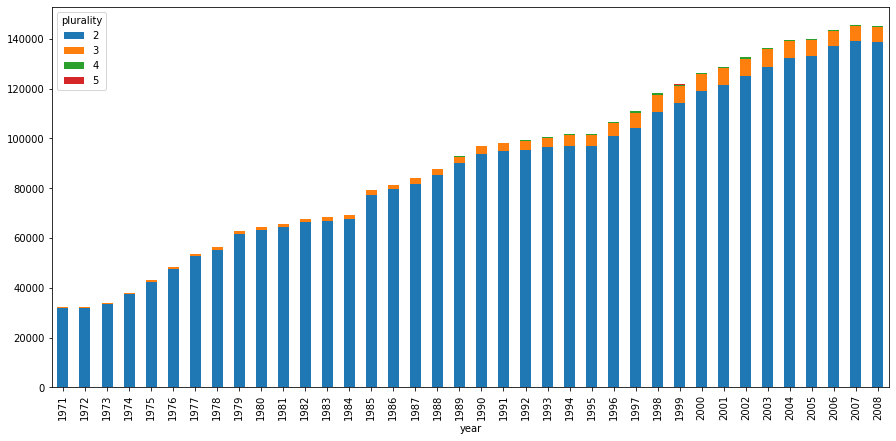

In [6]:
pivot_table = dfresult.pivot(index='year', columns='plurality', values='count')#reshape the data via the given index
pivot_table.plot(kind='bar', stacked=True, figsize=(15, 7));

In [0]:
#access our own dataset
sql = """
SELECT
    *
FROM
    `cmpelkk.iottest.test1`
ORDER BY
    timecollected
"""
dfiotquery = client.query(sql)

In [0]:
dfiot=dfiotquery.to_dataframe()

In [9]:
dfiot.head()

,registry_id,device_id,timecollected,zipcode,latitude,longitude,temperature,humidity,image_file
0,CMPEIoT1,cmpe181dev1,2020-04-27 14:43:15+00:00,95192,37.338820,-121.883518,34.30,76.46,img1.jpg
1,CMPEIoT1,cmpe181dev1,2020-04-27 14:43:16+00:00,95192,37.347024,-121.879376,32.55,77.07,img2.jpg
2,CMPEIoT1,cmpe181dev1,2020-04-27 14:51:35+00:00,95192,37.343941,-121.884800,33.98,65.71,img2.jpg
3,CMPEIoT1,cmpe181dev1,2020-04-27 14:51:35+00:00,95192,37.341744,-121.884609,22.55,73.89,img1.jpg
4,CMPEIoT1,cmpe181dev1,2020-04-27 14:51:36+00:00,95192,37.339297,-121.879203,22.52,75.66,img4.jpg


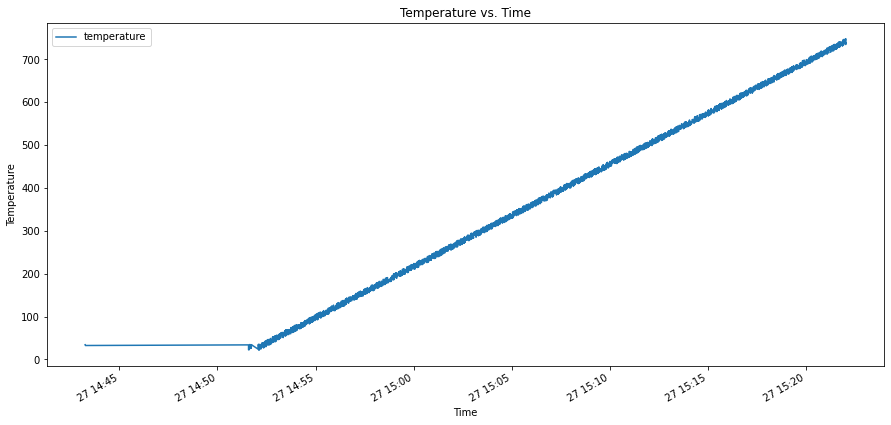

In [10]:
ax = dfiot.plot(kind='line', x='timecollected', y='temperature', figsize=(15,7))
ax.set_title('Temperature vs. Time')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature');

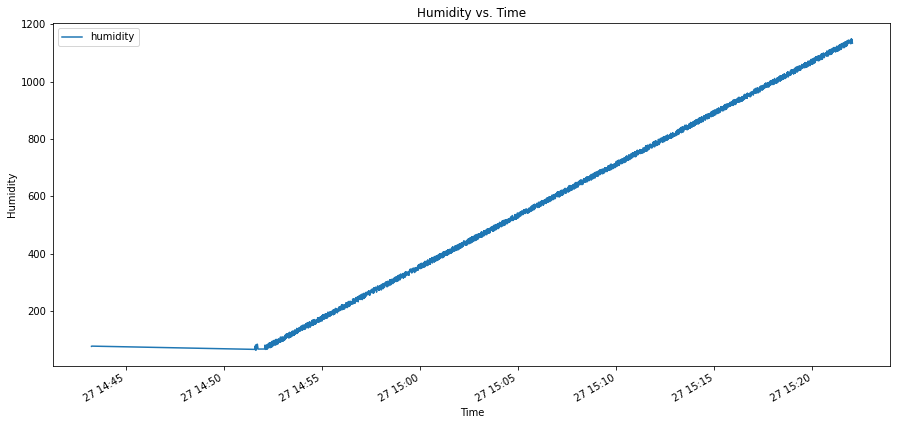

In [11]:
ax = dfiot.plot(kind='line', x='timecollected', y='humidity', figsize=(15,7))
ax.set_title('Humidity vs. Time')
ax.set_xlabel('Time')
ax.set_ylabel('Humidity');

In [0]:
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
geometry = [Point(xy) for xy in zip(dfiot["longitude"], dfiot["latitude"])]

In [16]:
!pip install geopandas

     |████████████████████████████████| 931kB 4.9MB/s 
     |████████████████████████████████| 10.4MB 17.0MB/s 
     |████████████████████████████████| 14.7MB 307kB/s 


In [0]:
import geopandas as gpd

In [18]:
geo_df = gpd.GeoDataFrame(dfiot, crs = {'init':'epsg:4326'}, geometry = geometry)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [19]:
geo_df.head()

,registry_id,device_id,timecollected,zipcode,latitude,longitude,temperature,humidity,image_file,geometry
0,CMPEIoT1,cmpe181dev1,2020-04-27 14:43:15+00:00,95192,37.338820,-121.883518,34.30,76.46,img1.jpg,POINT (-121.88352 37.33882)
1,CMPEIoT1,cmpe181dev1,2020-04-27 14:43:16+00:00,95192,37.347024,-121.879376,32.55,77.07,img2.jpg,POINT (-121.87938 37.34702)
2,CMPEIoT1,cmpe181dev1,2020-04-27 14:51:35+00:00,95192,37.343941,-121.884800,33.98,65.71,img2.jpg,POINT (-121.88480 37.34394)
3,CMPEIoT1,cmpe181dev1,2020-04-27 14:51:35+00:00,95192,37.341744,-121.884609,22.55,73.89,img1.jpg,POINT (-121.88461 37.34174)
4,CMPEIoT1,cmpe181dev1,2020-04-27 14:51:36+00:00,95192,37.339297,-121.879203,22.52,75.66,img4.jpg,POINT (-121.87920 37.33930)


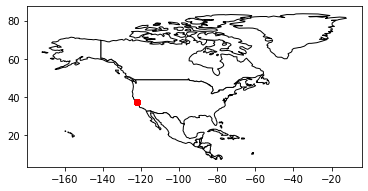

In [21]:
#we plot the coordinates over a country-level map.
#ref: https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
geo_df.plot(ax=ax, color='red')

plt.show()

In [0]:
sql = """
SELECT
    *
FROM
    `bigquery-public-data.covid19_nyt.us_states`
ORDER BY
    date
"""
dfquery = client.query(sql)

In [0]:
df_covid=dfquery.to_dataframe()

In [35]:
df_covid.head(200)

,date,state_name,state_fips_code,confirmed_cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
195,2020-02-25,Arizona,04,1,0
196,2020-02-25,Illinois,17,2,0
197,2020-02-25,Nebraska,31,13,0
198,2020-02-25,Wisconsin,55,1,0


In [0]:
is_California = df_covid['state_name']=='California'

In [37]:
df_ca=df_covid[is_California]
df_ca.head()

,date,state_name,state_fips_code,confirmed_cases,deaths
6,2020-01-25,California,06,1,0
10,2020-01-26,California,06,2,0
14,2020-01-27,California,06,2,0
18,2020-01-28,California,06,2,0
22,2020-01-29,California,06,2,0


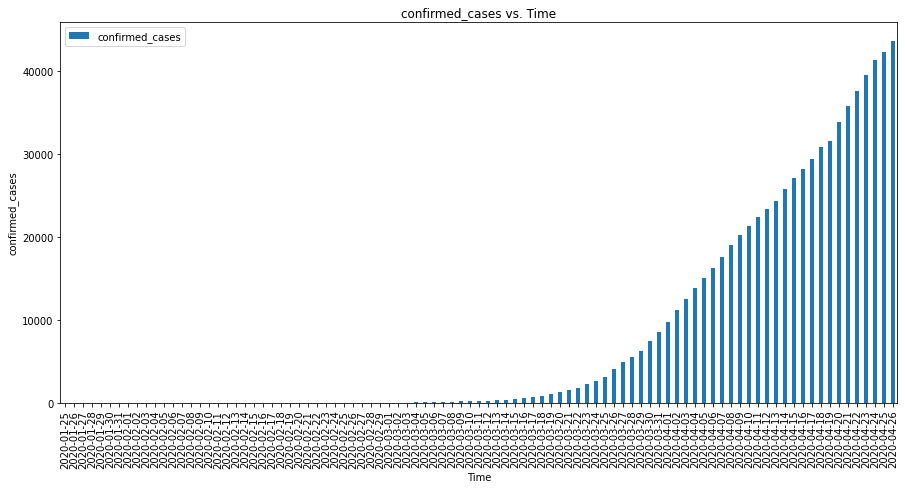

In [38]:
ax = df_ca.plot(kind='bar', x='date', y='confirmed_cases', figsize=(15,7))
ax.set_title('confirmed_cases vs. Time')
ax.set_xlabel('Time')
ax.set_ylabel('confirmed_cases');

# BigQuery GIS
ref: https://cloud.google.com/bigquery/docs/gis-getting-started


In [0]:
sql = """
SELECT
  ST_GeogPoint(longitude, latitude)  AS WKT,
  num_bikes_available
FROM
  `bigquery-public-data.new_york.citibike_stations`
WHERE num_bikes_available > 30
"""
dfquery = client.query(sql)

In [0]:
df_gis=dfquery.to_dataframe()

In [42]:
df_gis.head()

,WKT,num_bikes_available
0,POINT(-73.95600096 40.71774592),31
1,POINT(-73.94755757 40.7903051),35
2,POINT(-73.97109243 40.76350532),33
3,POINT(-73.99063168 40.6867443),35
4,POINT(-73.956461 40.813358),39


Visualize the query results in Geo Viz: https://bigquerygeoviz.appspot.com